### Import libraries

In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import random
from sklearn.metrics import accuracy_score
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Activation
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from keras.layers import BatchNormalization, GlobalAveragePooling2D
print(tf.__version__)

2.9.0


Reading 156 species and their corresponding labels

In [3]:
data_path = "Orchid_data/"

In [4]:
def read_species_label():
    with open(data_path + "/readme.txt", 'r') as f: #for reading lines 
        lines = f.readlines()
    species = lines[122:]
    species_var ={}
    for species_name in species:
        index, species_name = species_name.rstrip('\n').split("\t")
        species_name = species_name.rstrip('\xa0')
        index = int(index)
        species_var[index] = species_name

    return species_var

In [5]:
species_var = read_species_label()
#species_var

### Importing Data and Preprocessing

In [6]:
def parse_txt_file(file_path):
    df = pd.read_csv(file_path, header=None, dtype=str)
    col = ["Image_name","Species_Class"]
    df.columns = col
    return df

In [7]:
train_df = parse_txt_file(data_path + "/Species_Classifier/Training_Data_for_Species.txt")
train_df = train_df.reindex(np.random.permutation(train_df.index))
train_df = train_df.reset_index(drop=True)
train_df.head()

,Image_name,Species_Class
0,239.jpg,10
1,6100.jpg,128
2,5379.jpg,110
3,6387.jpg,133
4,1022.jpg,20


In [8]:
val_df = parse_txt_file(data_path + "/Species_Classifier/Validation_Data_for_Species.txt")
val_df.head()

,Image_name,Species_Class
0,25.jpg,1
1,26.jpg,1
2,7032.jpg,1
3,7033.jpg,1
4,7034.jpg,1


In [9]:
train_df.dtypes

Image_name       object
Species_Class    object
dtype: object

In [ ]:
train_df['Species_Class'] = train_df['Species_Class'].astype('int')
train_df['Species_Class'] = train_df['Species_Class'] -1

In [ ]:
val_df['Species_Class'] = val_df['Species_Class'].astype('int')
val_df['Species_Class'] = val_df['Species_Class'] -1

#### Class Imbalance

<Axes: >

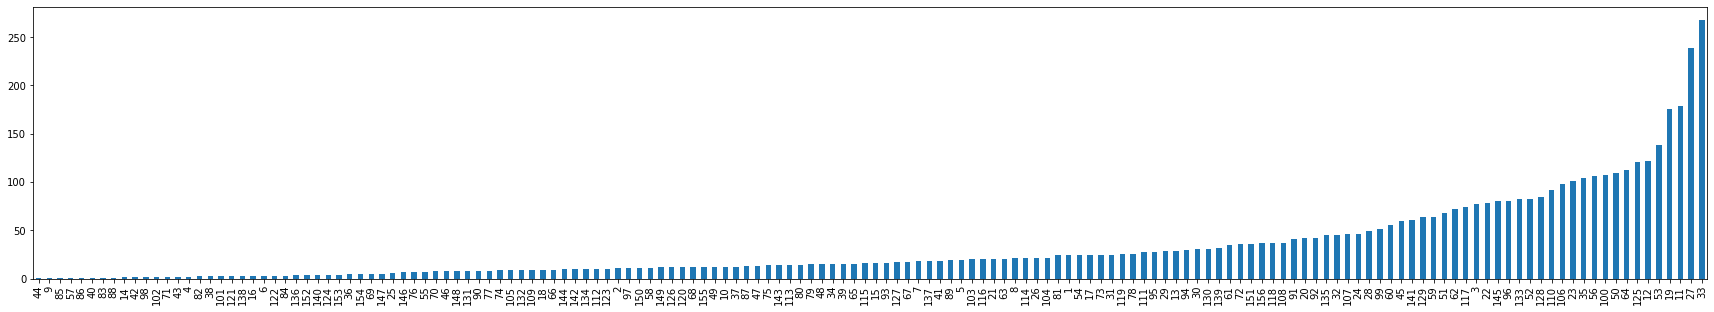

In [10]:
# plotting bar graph : Counting the different class species in the training data
train_df['Species_Class'] = train_df['Species_Class'].astype(int)
train_df.Species_Class.value_counts().sort_values().plot(kind='bar', figsize=(30, 5)) 

As we can see from above that there is a class imbalance in the data. For example Classes like 83,44 etc have just one instance and Classes like 27,33 have high instance in the training data. In order to handle class imbalance, we can following things:

1. Oversampling
2. Penalizing the model more if error occurs in the minority class
3. Data Augmentation

### Visualizing some random example from training data

In [11]:
train_df.head()

,Image_name,Species_Class
0,239.jpg,10
1,6100.jpg,128
2,5379.jpg,110
3,6387.jpg,133
4,1022.jpg,20


In [12]:
image_name = train_df['Image_name'][0]
image_path = data_path + '/Orchid_Images/' + image_name
print(image_path)


Orchid_data//Orchid_Images/239.jpg


#### We will do some data visualization

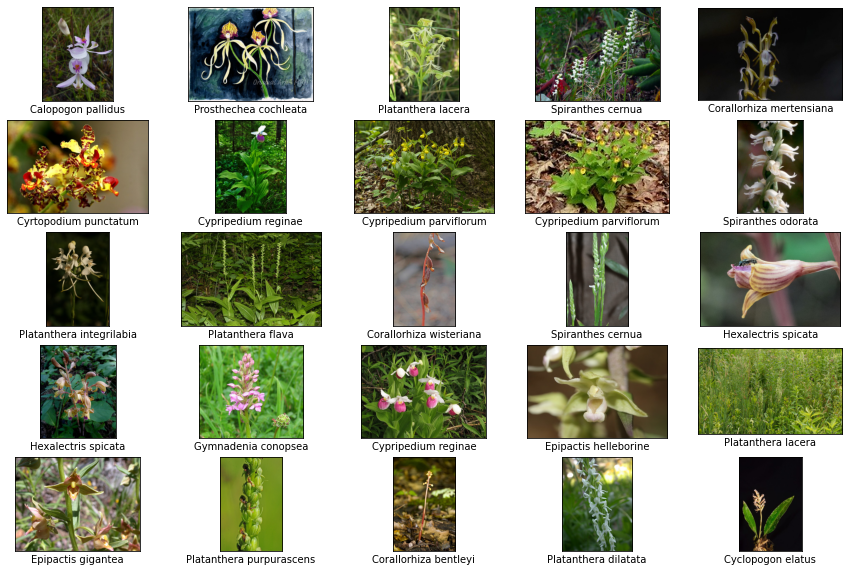

In [13]:
plt.figure(figsize=(15,10))

for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    image_name = train_df['Image_name'][i]
    image_path = data_path + '/Orchid_Images/' + image_name
    image = plt.imread(image_path)
    plt.imshow(image)
    cls_lb = int(train_df['Species_Class'][i])
    cls_name = species_var[cls_lb]
    plt.xlabel(cls_name)

Since different images have different sizes, so we will choose a fix input size for the model.We will choose input size as 32x32

### Data Augmentation

We are using data augmentation to increase the amount of data by adding slightly modified copies of already existing data or newly created synthetic data from existing data. It acts as a regularizer and helps reduce overfitting when training a machine learning model.

In [14]:
def prepare_data_pipeline(
    rescale=None, preprocessing_fn=None, target_size=(32, 32)
):
    train_image_gen = ImageDataGenerator(
        rescale=rescale,
        #featurewise_center=True,
        #featurewise_std_normalization=True,
        rotation_range=30,
        width_shift_range=0.15,
        height_shift_range=0.15,
        horizontal_flip=True,
        preprocessing_function=preprocessing_fn
    )
    
    valid_image_gen = ImageDataGenerator(
        rescale=rescale, preprocessing_function=preprocessing_fn
    )
    
    train_df['Species_Class'] = train_df['Species_Class'].astype(str)

    train_generator = train_image_gen.flow_from_dataframe(
    dataframe = train_df,
    directory = data_path + "/Orchid_Images",
    x_col="Image_name",
    y_col="Species_Class",
    subset=None,
    batch_size=32,
    seed=123,
    shuffle=True,
    class_mode="sparse",
    target_size=target_size)


    valid_generator = valid_image_gen.flow_from_dataframe(
    dataframe=val_df,
    directory=data_path + "/Orchid_Images",
    x_col="Image_name",
    y_col="Species_Class",
    subset=None,
    batch_size=32,
    class_mode="sparse",
    target_size=target_size)
    
    return train_generator, valid_generator

In [15]:
train_generator, valid_generator = prepare_data_pipeline(rescale=1./255)

Found 5119 validated image filenames belonging to 156 classes.
Found 1235 validated image filenames belonging to 156 classes.


### Naive Model

In [19]:
from sklearn.metrics import classification_report

# making Naive model
def naive_model_errors(train_df, val_df): 
    random.seed(1234)
    print("Accuracy using Naive Model")
    total_train = train_df['Species_Class'].shape[0]
    total_val = val_df['Species_Class'].shape[0]
    train_prob = train_df.Species_Class.value_counts()/total_train
    train_prob = dict(train_prob)
    cls_lbs = []
    cls_prob = []
    for lb, prob in train_prob.items():
        cls_lbs.append(int(lb))
        cls_prob.append(prob)


    train_prd= random.choices(cls_lbs, weights= cls_prob, k=total_train)
    val_prd= random.choices(cls_lbs, weights=cls_prob, k=total_val)

    #accuracy_train = accuracy_score(train_df['Species_Class'].astype(int), train_prd)
    accuracy_val = accuracy_score(val_df['Species_Class'].astype(int), val_prd)
    #print("Training Accuracy: " + str(accuracy_train))
    print("Validation Accuracy: " + str(accuracy_val))


In [20]:
naive_model_errors(train_df, val_df)

Accuracy using Naive Model
Validation Accuracy: 0.01700404858299595


Naive model performance is 1.7% which is very low.Our aim is to build a model which performs better than this Naive Model

### a. Building Model 1 from scratch using CNN layers

In [21]:
def make_cnn_model(input_shape=(32,32,3)):
    # start building model
    model = Sequential(name="model_cnn")
    # Feature extraction
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    #1. first hidden layers = 32 filters (neurons, capacity), kernel = (3,3), zero padding
    model.add(Activation('relu'))
    model.add(Conv2D(32,(3, 3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2))) # we're pulling over size two by two. For every two rows and two columns, we select only one
                                            # So we are looking at two rows, two columns, getting the maximum out of those.
    model.add(Dropout(0.25))

    model.add(Conv2D(32, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3,3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
 
    # Mapping Process (Map the features to the classes)
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    # Output classes are 156
    model.add(Dense(156))
    model.add(Activation('softmax'))


    # compile model 
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [22]:
model = make_cnn_model(input_shape=(32,32,3))

In [23]:
model.summary()

Model: "model_cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 30, 30, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 15, 15, 32)        0         
                                                         

In [24]:
def fit_model(model, train_gen, valid_gen, num_epochs=50): 
    
    print("\nTraining model")
    model.reset_states()
    m_history = model.fit(
      x=train_gen, validation_data=valid_gen, epochs=num_epochs, verbose=1
    )

    print("\n")
    print("=====================")

    return model, m_history

In [25]:
model, m_history = fit_model(
    model, train_gen=train_generator, valid_gen=valid_generator, num_epochs=100
)


Training model
Epoch 1/100
160/160 [==============================] - 13s 76ms/step - loss: 4.5112 - accuracy: 0.0590 - val_loss: 4.2377 - val_accuracy: 0.0826
Epoch 2/100
160/160 [==============================] - 12s 75ms/step - loss: 4.1586 - accuracy: 0.0945 - val_loss: 3.9766 - val_accuracy: 0.1231
Epoch 3/100
160/160 [==============================] - 12s 73ms/step - loss: 3.9353 - accuracy: 0.1221 - val_loss: 3.7304 - val_accuracy: 0.1951
Epoch 4/100
160/160 [==============================] - 12s 73ms/step - loss: 3.7254 - accuracy: 0.1524 - val_loss: 3.5188 - val_accuracy: 0.2170
Epoch 5/100
160/160 [==============================] - 12s 73ms/step - loss: 3.5566 - accuracy: 0.1801 - val_loss: 3.3431 - val_accuracy: 0.2356
Epoch 6/100
160/160 [==============================] - 12s 74ms/step - loss: 3.4052 - accuracy: 0.2108 - val_loss: 3.2833 - val_accuracy: 0.2478
Epoch 7/100
160/160 [==============================] - 12s 74ms/step - loss: 3.2819 - accuracy: 0.2227 - val_loss:

In [26]:
def plot_history_models(histories, key='loss', ylim=[0, 1]):
    plt.figure(figsize=(7,5), dpi=150)
    for name, history in histories:
        val = plt.plot(history.epoch, history.history['val_'+key],
                   '--', label=name.title()+' Val')
        plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
             label=name.title()+' Train')

    plt.xlabel('Epochs')
    plt.ylabel(key.replace('_',' ').title())
    plt.legend()

    plt.xlim([0,max(history.epoch)])
    plt.ylim(ylim)
    plt.grid()

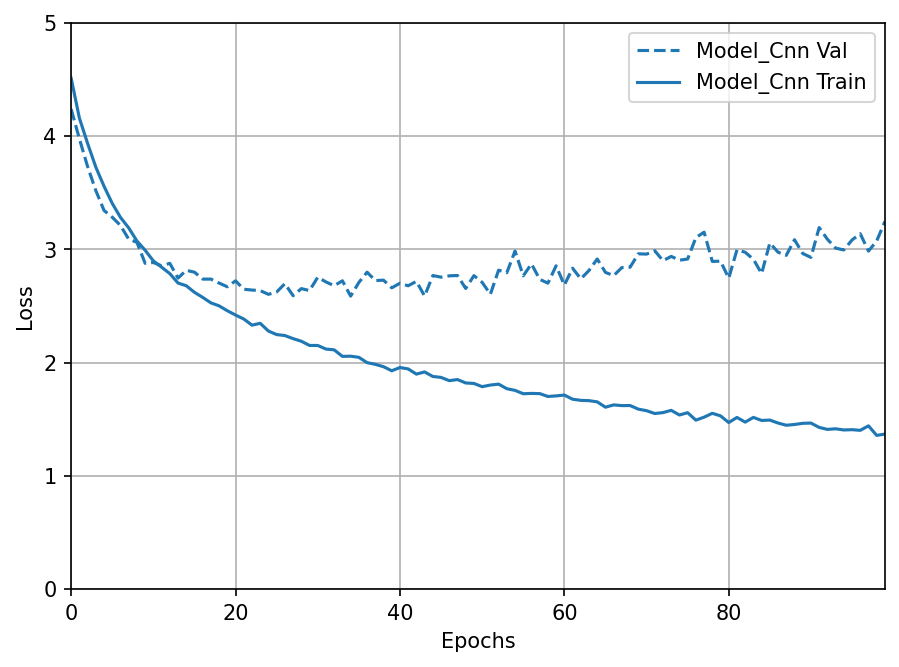

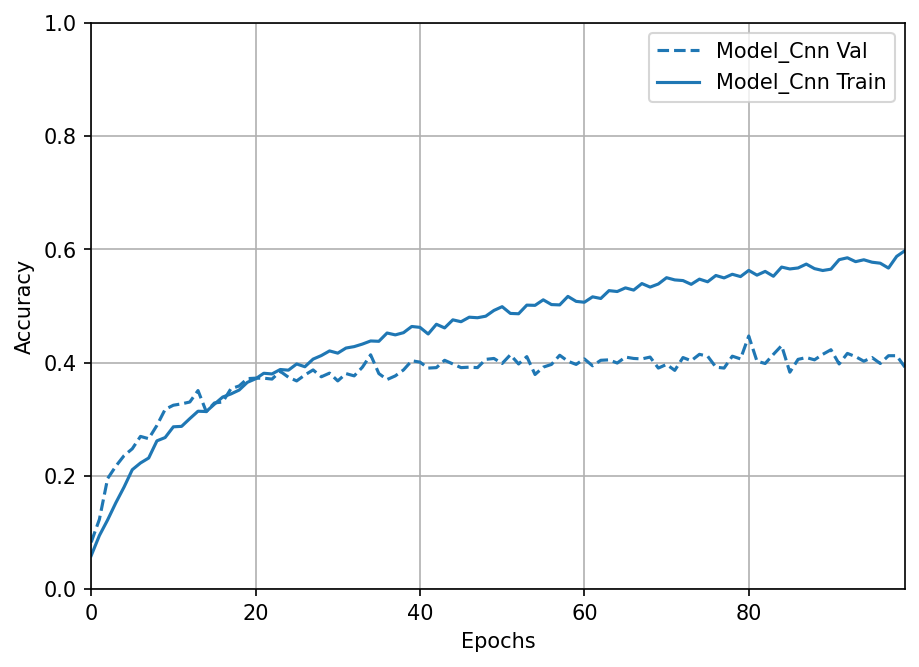

In [27]:
plot_history_models([('Model_CNN', m_history)], key='loss', ylim=[0,5.0])
plot_history_models([('Model_CNN', m_history)], key='accuracy', ylim=[0, 1.0])

From the plot of 100 epochs, we can see that the train loss is decreasing and validation loss is increasing  which indicates overfitting

### Comparison with Naive Model

The highest accuracy for the CNN model is 44.7% at epoch 81, however we can see that the model is overfitting.There are several ways to improve our model : 

- Early stopping
- Hyper parameter tuning
- Change % Dropout
- Transfer Learning

Since our CNN model have higher accuracy than Naive Model(1.17%),we can say our CNN model is better in performance.

We will be building a tranfer learning model and see if the performance improves than the above CNN model

### Model 2: Use Transfer learning

In [28]:
def transfer_learn_model(input_shape=(32, 32, 3)) :
    base_model = tf.keras.applications.ResNet50V2(input_shape=input_shape,
                                              include_top=False,
                                              weights='imagenet')
    base_model.trainable = False
    model_tl = Sequential()
    model_tl.add(base_model)
    model_tl.add(GlobalAveragePooling2D())
    model_tl.add(Dense(512))
    model_tl.add(Activation('relu'))
    model_tl.add(Dropout(0.5))
    model_tl.add(Dense(156))
    model_tl.add(Activation('softmax'))
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model_tl.compile(
        optimizer, loss='sparse_categorical_crossentropy',metrics=['accuracy']
    )
    return model_tl

In [29]:
model_tl = transfer_learn_model(input_shape=(224, 224, 3))

In [30]:
train_generator, valid_generator = prepare_data_pipeline(
    preprocessing_fn=tf.keras.applications.resnet_v2.preprocess_input,
    target_size=(224, 224)
)

model_tl, m_history_tl = fit_model(
    model_tl, train_gen=train_generator, valid_gen=valid_generator, num_epochs=100
)

Found 5119 validated image filenames belonging to 156 classes.
Found 1235 validated image filenames belonging to 156 classes.

Training model
Epoch 1/100
160/160 [==============================] - 60s 366ms/step - loss: 4.5909 - accuracy: 0.1067 - val_loss: 3.8284 - val_accuracy: 0.2300
Epoch 2/100
160/160 [==============================] - 57s 356ms/step - loss: 3.7850 - accuracy: 0.2176 - val_loss: 3.3956 - val_accuracy: 0.2842
Epoch 3/100
160/160 [==============================] - 1345s 8s/step - loss: 3.3983 - accuracy: 0.2790 - val_loss: 3.1253 - val_accuracy: 0.3312
Epoch 4/100
160/160 [==============================] - 62s 385ms/step - loss: 3.0916 - accuracy: 0.3223 - val_loss: 2.9172 - val_accuracy: 0.3692
Epoch 5/100
160/160 [==============================] - 62s 386ms/step - loss: 2.8647 - accuracy: 0.3591 - val_loss: 2.7562 - val_accuracy: 0.3960
Epoch 6/100
160/160 [==============================] - 65s 406ms/step - loss: 2.6719 - accuracy: 0.3870 - val_loss: 2.6381 - val_

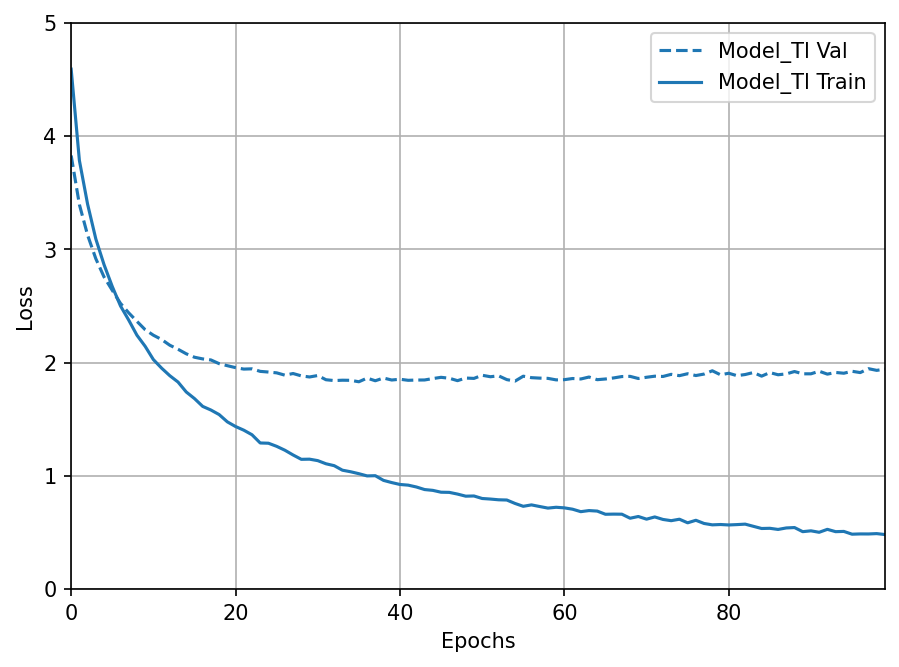

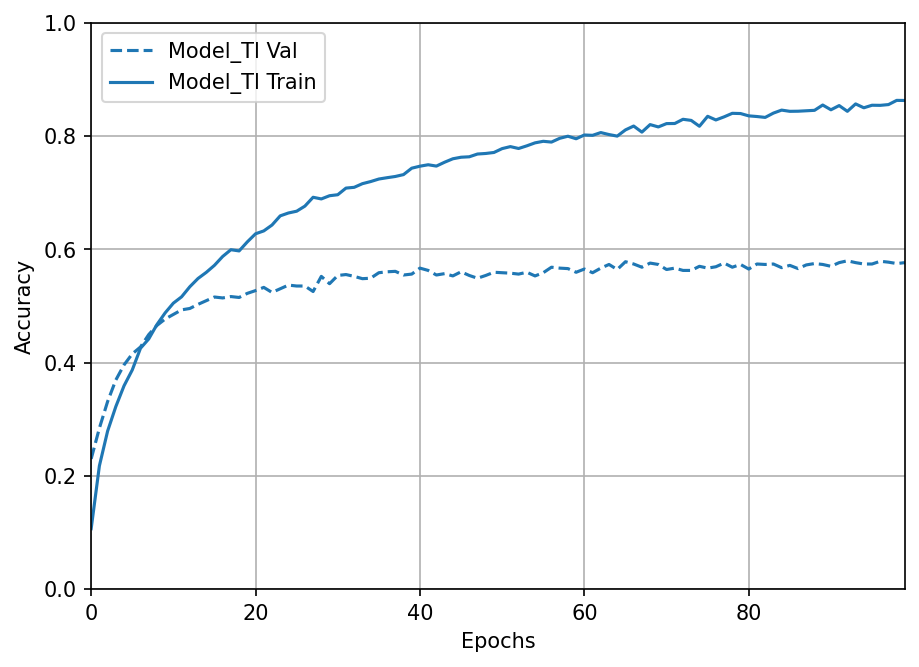

In [31]:
plot_history_models([('Model_tl', m_history_tl)], key='loss', ylim=[0,5.0])
plot_history_models([('Model_tl', m_history_tl)], key='accuracy', ylim=[0, 1.0])

From the plot results for loss, we can see that validation loss is higher than training loss,thus the model is overfitting

### Comparison with Naive Model and first CNN model.



Both CNN and Transfer Learning Model are better than the Naive Model.If we compare these two :  CNN and transfer learning model, we can see that transfer learning model is doing better. The highest accuracy for transfer learning model is at epoch 93 which ia 57.98% whereas highest CNN model accuracy was at 41 epoch which is 44.7%.

Also, we can see that the overiftting has been reduced. Further, we noticed from train and validation loss plot that the model has not converged yet.And therefore, training it for more than 100 epochs will likely give a better model achieveing even higher accuracy.Due to resource constraint, we train this model for only 100 epochs.